In [1]:
from google.colab import drive
drive.mount('/content/drive')

file_name = '/content/drive/MyDrive/submission/7015_final/result_metrics/all_result.csv'

Mounted at /content/drive


<ipython-input-7-089ce208dd96>:71: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 1, 0.98])  # Adjust layout


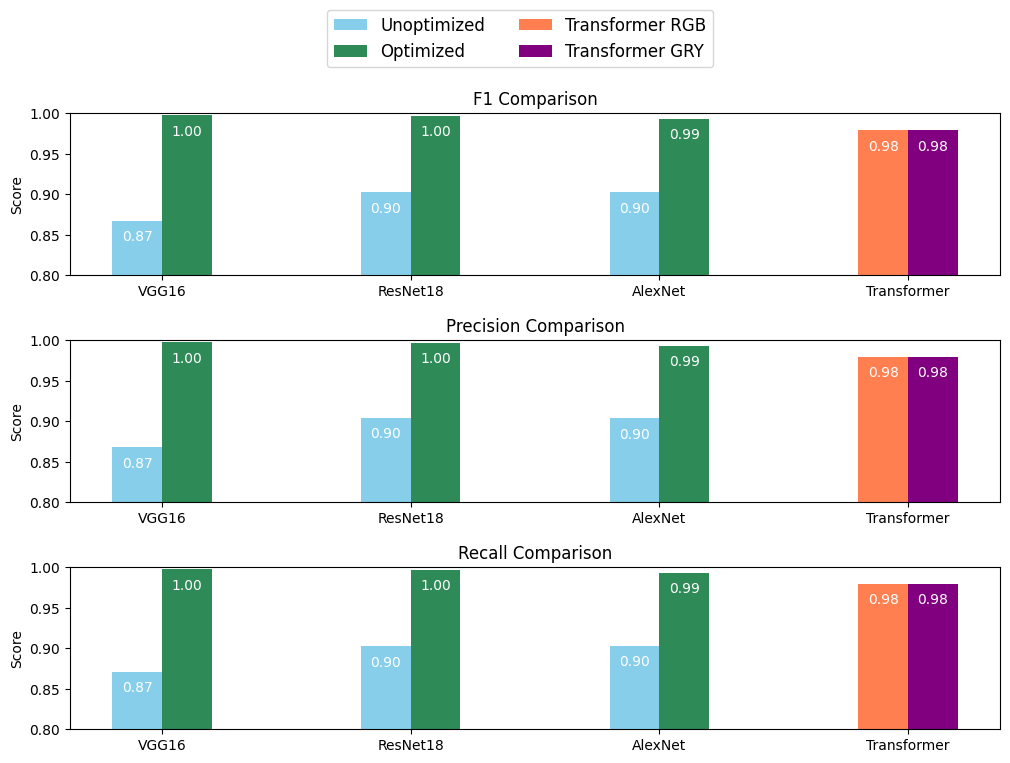

<ipython-input-7-089ce208dd96>:114: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.88, 1])  # Ensure the colorbar does not overlap


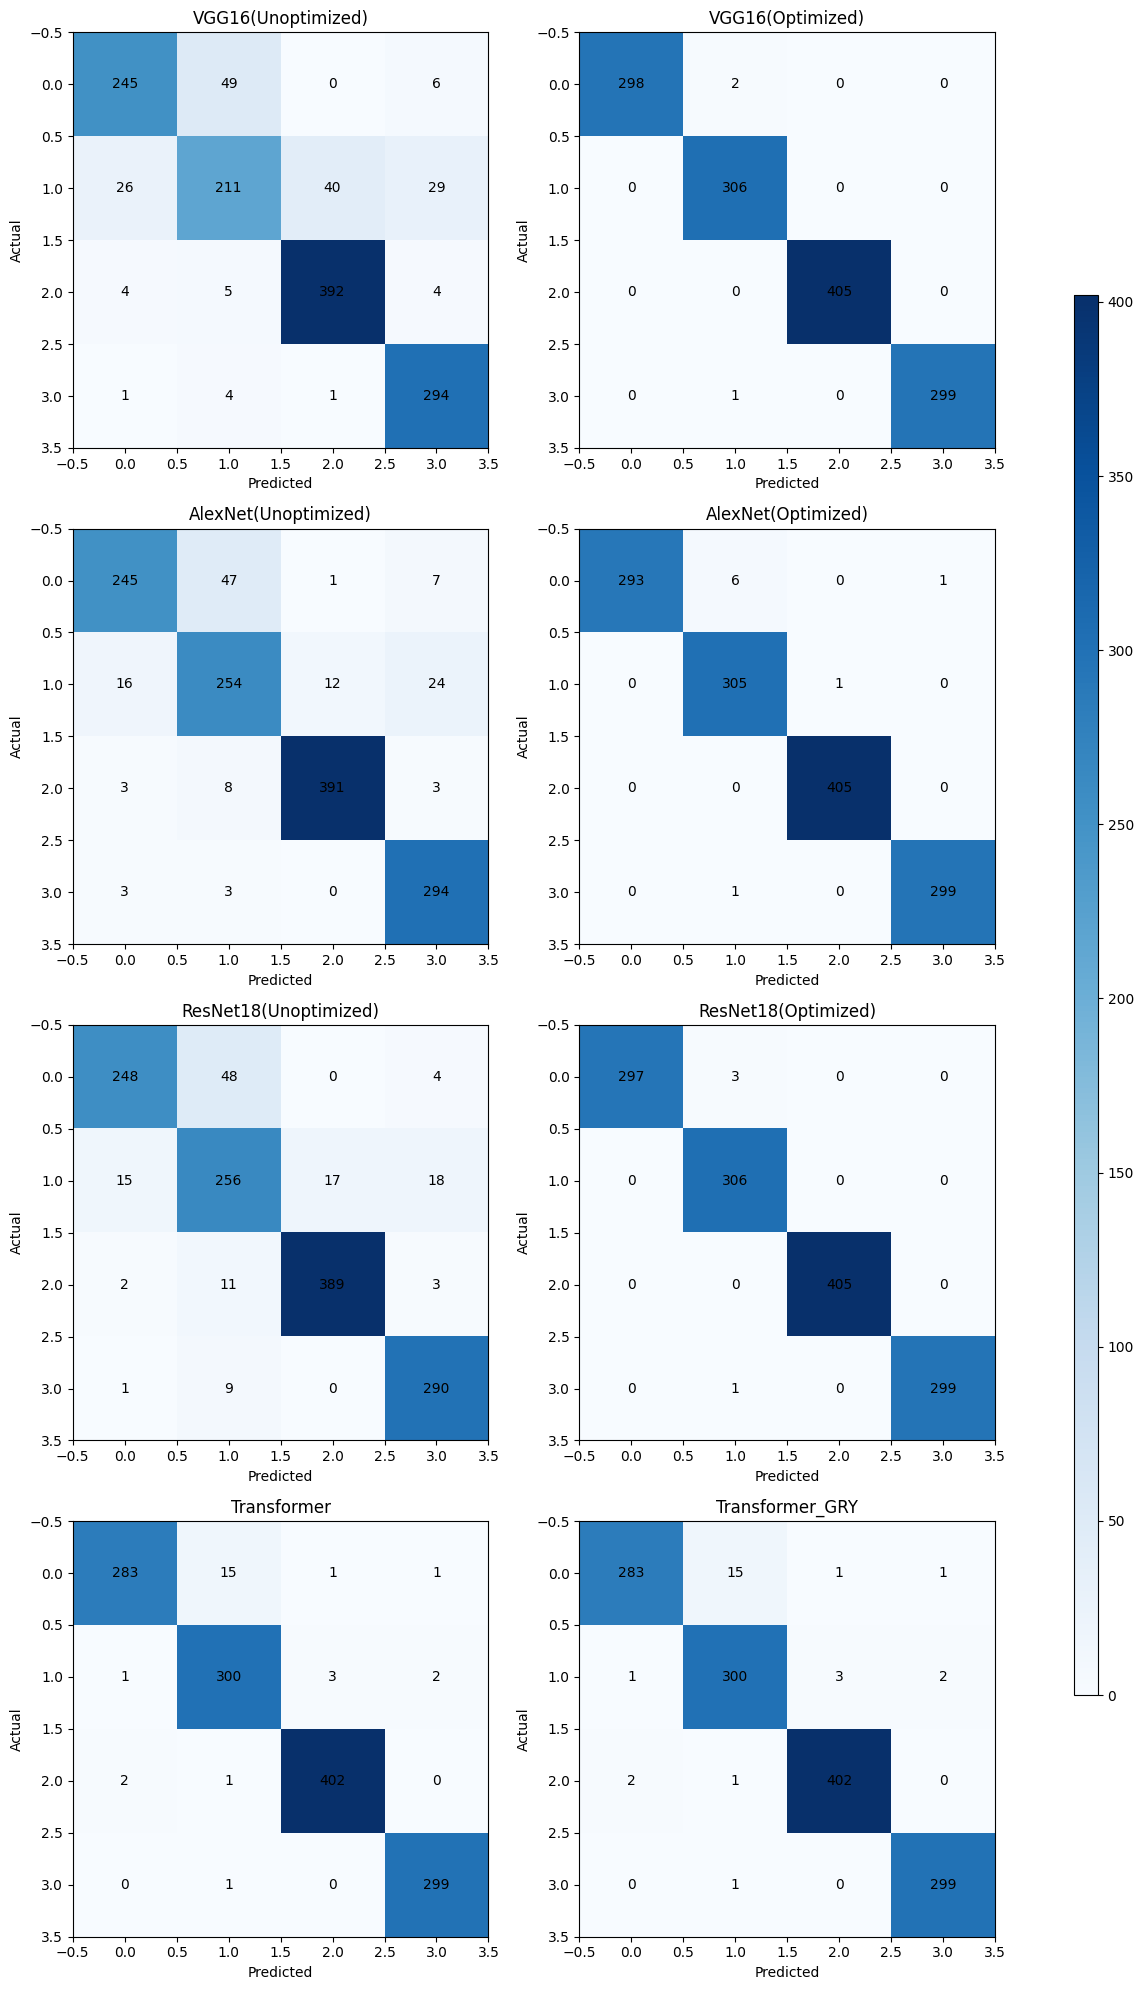

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load the CSV file
baseline_results = pd.read_csv(file_name)

# Add a column for Transformer type
baseline_results['Transformer'] = baseline_results['Model'].apply(
    lambda x: 'Transformer RGB' if 'Transformer' in x and 'GRY' not in x else (
        'Transformer GRY' if 'Transformer_GRY' in x else 'Other'
    )
)

# Separate Unoptimized, Optimized, and Transformer models
unoptimized_metrics = baseline_results[baseline_results['Model'].str.contains('Unoptimized')].reset_index()
optimized_metrics = baseline_results[baseline_results['Model'].str.contains('Optimized')].reset_index()
transformer_rgb_metrics = baseline_results[baseline_results['Transformer'] == 'Transformer RGB'].reset_index()
transformer_gry_metrics = baseline_results[baseline_results['Transformer'] == 'Transformer GRY'].reset_index()

# Validation Metrics Comparison - Three charts for three metrics
fig, axes = plt.subplots(3, 1, figsize=(12, 8), gridspec_kw={'hspace': 0.4})  # Compact layout

metrics = ['F1', 'Precision', 'Recall']
colors = ['skyblue', 'seagreen', 'coral', 'purple']  # Colors for Unoptimized, Optimized, RGB Transformer, GRY Transformer

for idx, metric in enumerate(metrics):
    # Get data for Unoptimized, Optimized, and Transformers
    unopt_values = unoptimized_metrics[f'Val_{metric}']
    opt_values = optimized_metrics[f'Val_{metric}']
    trans_rgb_value = transformer_rgb_metrics[f'Val_{metric}'].mean()
    trans_gry_value = transformer_gry_metrics[f'Val_{metric}'].mean()

    # Adjust X-axis positions
    x_labels = unoptimized_metrics['Model'].str.split("(", expand=True)[0].tolist()
    x = np.arange(len(x_labels) + 1)  # Add position for Transformer group

    width = 0.2  # Bar width

    # Adjust bar positions to make group bars closer together
    group_offset = 0.1  # Reduce the gap between bars in the same group
    bars_unopt = axes[idx].bar(x[:-1] - group_offset, unopt_values, width, label='Unoptimized', color=colors[0])
    bars_opt = axes[idx].bar(x[:-1] + group_offset, opt_values, width, label='Optimized', color=colors[1])

    bars_trans_rgb = axes[idx].bar(x[-1] - group_offset, trans_rgb_value, width, label='Transformer RGB', color=colors[2])
    bars_trans_gry = axes[idx].bar(x[-1] + group_offset, trans_gry_value, width, label='Transformer GRY', color=colors[3])

    # Annotate bars for Unoptimized and Optimized
    for bar_group in [bars_unopt, bars_opt]:
        for bar in bar_group:
            height = bar.get_height()
            axes[idx].text(bar.get_x() + bar.get_width() / 2, height - 0.02, f"{height:.2f}",
                           ha='center', va='center', color='white', fontsize=10)

    # Annotate bars for Transformers
    for bar, value in zip([bars_trans_rgb[0], bars_trans_gry[0]], [trans_rgb_value, trans_gry_value]):
        axes[idx].text(bar.get_x() + bar.get_width() / 2, value - 0.02, f"{value:.2f}",
                       ha='center', va='center', color='white', fontsize=10)

    # Adjust X-axis labels to align with group centers
    axes[idx].set_xticks(x)
    axes[idx].set_xticklabels(x_labels + ['Transformer'], rotation=0, ha='center')  # Centered labels
    axes[idx].set_title(f"{metric} Comparison", fontsize=12)
    axes[idx].set_ylim(0.8, 1.0)  # Focus range
    axes[idx].set_ylabel('Score')

# Add legend outside the charts
fig.legend(labels=['Unoptimized', 'Optimized', 'Transformer RGB', 'Transformer GRY'], loc='upper center',
           bbox_to_anchor=(0.5, 1.02), ncol=2, fontsize=12)

plt.tight_layout(rect=[0, 0, 1, 0.98])  # Adjust layout
plt.show()

# Confusion Matrix Comparison - Custom arrangement
# Define a custom ordering of models
custom_order = [
    "VGG16(Unoptimized)", "VGG16(Optimized)",
    "AlexNet(Unoptimized)", "AlexNet(Optimized)",
    "ResNet18(Unoptimized)", "ResNet18(Optimized)",
    "Transformer", "Transformer_GRY"
]

# Sort the dataframe by this custom order
baseline_results['Sort_Order'] = baseline_results['Model'].apply(lambda x: custom_order.index(x))
baseline_results = baseline_results.sort_values('Sort_Order').reset_index()

# Confusion Matrix Comparison - Four rows and two columns
fig, axes = plt.subplots(4, 2, figsize=(12, 20))  # Fixed layout for 4 rows and 2 columns

# Plot confusion matrices for all models
confusion_matrices = baseline_results['Val_Confusion_Matrix']
for i in range(len(baseline_results)):
    cm = eval(confusion_matrices[i])  # Convert string to list
    row = i // 2
    col = i % 2
    ax = axes[row, col]

    im = ax.imshow(cm, interpolation='nearest', cmap='Blues')
    model_name = baseline_results['Model'][i]
    ax.set_title(f"{model_name}")
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')

    # Add values to confusion matrix
    for j in range(len(cm)):
        for k in range(len(cm[j])):
            ax.text(k, j, str(cm[j][k]), ha="center", va="center", color="black")

# Add a shared colorbar outside the grid
fig.subplots_adjust(right=0.88)  # Adjust space for colorbar
cbar_ax = fig.add_axes([0.9, 0.15, 0.02, 0.7])  # Position for the colorbar
fig.colorbar(im, cax=cbar_ax, orientation='vertical')

plt.tight_layout(rect=[0, 0, 0.88, 1])  # Ensure the colorbar does not overlap
plt.show()
